In [1]:
from training_functions import *
from merging import *
from utils import *
from model_evaluation import ModelEvaluation
from misc_utils.augment_preds import join_data_and_preds_icsd, join_data_and_preds_exp
import pandas as pd

2024-10-21 10:06:58.408309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 10:06:59.619245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
preds_mp = pd.read_csv("datasets/exported.predictions.mp.v2.csv")
ref_mp = pd.read_csv("datasets/mp_Laskowski2023_map.csv")

preds_mp_exp_initial = join_data_and_preds_exp(
    df_preds_full_mp=preds_mp,
    df_data_exp_mp=ref_mp,
)

preds_icsd_exp = join_data_and_preds_icsd(
    df_preds_icsd=pd.read_csv("datasets/exported.predictions.icsd.v3.csv"),
    df_data_exp_full=pd.read_csv("datasets/digitized_data_for_SSEs.csv"),
)

preds_mp_exp = pd.concat([preds_mp_exp_initial, preds_icsd_exp], axis=0).reset_index(drop=True)

In [3]:
from misc_utils import augment_Kahle2020
from misc_utils import augment_preds

df_Kahle2020 = augment_Kahle2020.read_and_augment(
    "data_slim.csv",
)

df_Kahle2020 = df_Kahle2020[(df_Kahle2020['temperature'] == 1000) & (df_Kahle2020['group'] != 'D')]

df_Kahle2020 = df_Kahle2020[[
 'diffusion_mean_cm2_s',
 'diffusion_std_cm2_s',
 'diffusion_sem_cm2_s',
 'label',
 'src_database',
 'src_id',
 'group',
 'log_diffusion_mu',
 'log_diffusion_sigma',
 'log_diffusion_KL',
 'extrapolation_chi2ndof',
 'n_Li',
 'NE_conductivity_S_cm',
 'log_NE_conductivity_mu',
 'ffs_size']]

Estimating lognorm D parameters


Making initial guess:   0%|          | 0/195 [00:00<?, ?it/s]

2024-10-21 10:07:13.117809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21365 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:06:00.0, compute capability: 8.6
2024-10-21 10:07:13.118419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8944 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5
2024-10-21 10:07:13.118902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9783 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


refining:   0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
df_kahle_fin_nn = get_nn_features_kahle()

X_kahle_nn = df_kahle_fin_nn.drop([ 
    'src_id',
    'diffusion_mean_cm2_s',
    'stru_label', 
    'stru_id', 
    'structure', 
    'group', 
    'label', 
    'diffusion_sem_cm2_s', 
    'n_Li', 
    'sigma_S_cm', 
    'sigma_S_cm_sem', 
    'sigma_S_cm_err',
 ], axis=1)

df_mpdb_nn = get_nn_features_mpdb()

X_mpdb_nn = df_mpdb_nn.drop([ 
    'material_id',
 ], axis=1)

In [5]:
df_mp_exp = get_nn_features_exp()
X_exp_nn = df_mp_exp.drop(['material_id', 'sample_weight'], axis = 1)

In [6]:

feature_names_nn = X_kahle_nn.columns.tolist()
feature_names_nn = np.array(feature_names_nn)

X_kahle_nn = X_kahle_nn.to_numpy()
X_mpdb_nn = X_mpdb_nn.to_numpy()
X_exp_nn = X_exp_nn.to_numpy()

scaler = StandardScaler().fit(X_mpdb_nn)

X_mpdb_nn = scaler.transform(X_mpdb_nn)
X_kahle_nn = scaler.transform(X_kahle_nn)
X_exp_nn = scaler.transform(X_exp_nn)

cnt_and_name_features_nn = {
    'robust': 3,
    'connected': 16,
    'disconnected': 16
    }

feature_weights_nn = [1 / cnt_and_name_features_nn[(x.split('_')[-2])] for x in feature_names_nn]

In [7]:
from misc_utils import augment_Kahle2020, augment_preds

df_Kahle2020 = augment_Kahle2020.read_and_augment(
    "data_slim.csv",
)

Estimating lognorm D parameters


Making initial guess:   0%|          | 0/195 [00:00<?, ?it/s]

refining:   0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
df_Kahle2020 = augment_Kahle2020.read_and_augment(
        "data_slim.csv",
    )

preds_Kahle2020 = augment_preds.join_data_and_preds_Kahle2020(
        df_preds=pd.read_csv("datasets/exported.predictions.Kahle2020.v2.csv"),
        df_data=df_Kahle2020,
    )

Estimating lognorm D parameters


Making initial guess:   0%|          | 0/195 [00:00<?, ?it/s]

refining:   0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
params = {
        "max_depth": 2,
        "learning_rate" : 0.1,
        "iterations": 40,
    }

pipeline_catboost = ModelEvaluation(df_kahle_fin_nn, preds_Kahle2020, model_name = 'catboost', params = params)
pipeline_catboost.fit(X_kahle_nn, feature_weights_nn, thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names_nn)

pipeline_catboost.evaluate(num_of_evaluations = 30, X_mpdb = X_mpdb_nn, X_exp = X_exp_nn)
pipeline_catboost.get_aggregated_statistics()


  0%|          | 0/30 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.881207400194742
test roc-auc mean: 0.7129261962367516, std: 0.05691268849197721
mean train roc-auc: 0.8694997654083838


  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:10<05:18, 10.99s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 2/30 [00:21<05:03, 10.85s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 3/30 [00:32<04:53, 10.87s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [00:43<04:45, 10.98s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:54<04:33, 10.93s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 6/30 [01:05<04:21, 10.91s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 7/30 [01:16<04:10, 10.91s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 8/30 [01:27<03:59, 10.89s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 9/30 [01:38<03:50, 10.99s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 10/30 [01:49<03:40, 11.05s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 11/30 [02:00<03:29, 11.02s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 12/30 [02:11<03:17, 10.97s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 13/30 [02:22<03:07, 11.02s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 14/30 [02:33<02:55, 10.97s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 15/30 [02:44<02:44, 10.97s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 16/30 [02:55<02:33, 10.97s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 17/30 [03:06<02:21, 10.92s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 18/30 [03:17<02:12, 11.02s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 19/30 [03:28<02:00, 10.97s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 20/30 [03:39<01:49, 10.93s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 21/30 [03:50<01:38, 10.91s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 22/30 [04:01<01:27, 10.94s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 23/30 [04:12<01:17, 11.06s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 24/30 [04:23<01:06, 11.02s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 25/30 [04:34<00:55, 11.02s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 26/30 [04:45<00:44, 11.05s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 27/30 [04:56<00:32, 10.98s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 28/30 [05:07<00:22, 11.03s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 29/30 [05:18<00:11, 11.02s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 30/30 [05:29<00:00, 10.99s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
pipeline_catboost.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.869285
1,roc_auc on test by aggregated preds,0.710160
2,mean test roc-auc averaged by 40 models,0.706115
3,roc_like_comparison by aggregated preds,15.608753
4,roc_like_comparison averaged by 40 models,13.916286
5,roc_like_comparison std,2.742110


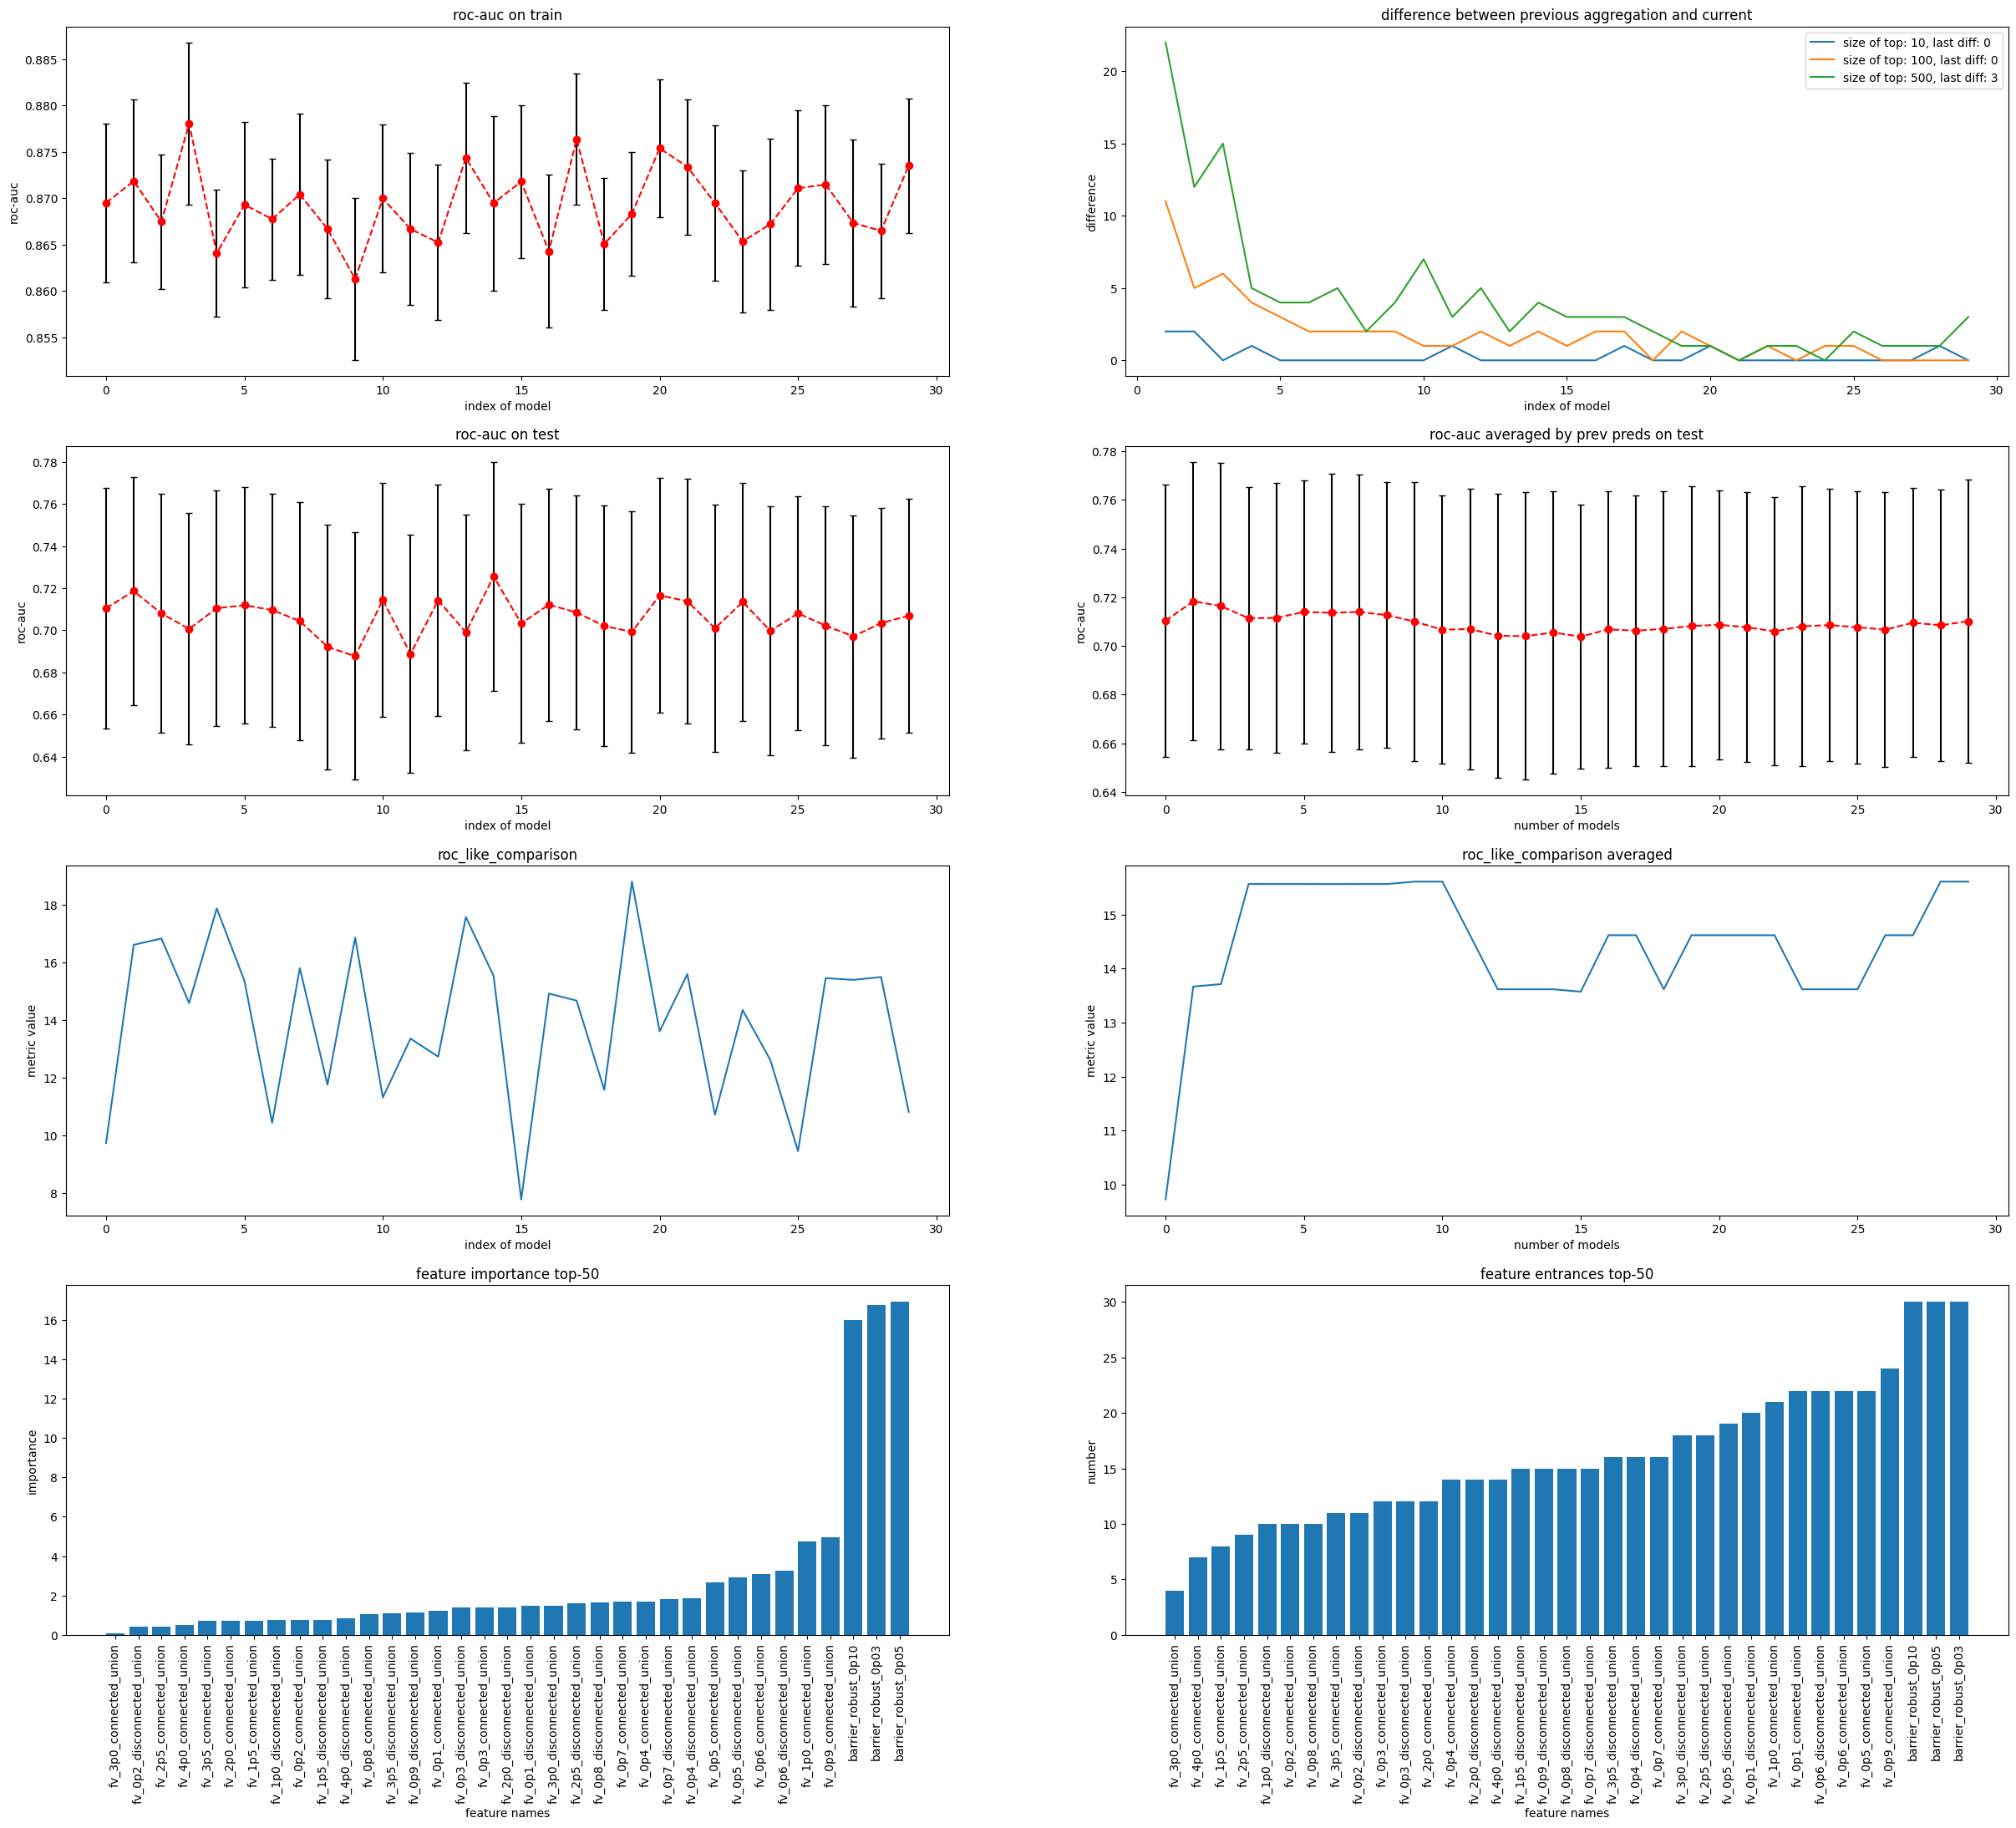

In [16]:
pipeline_catboost.plot_statistics()

In [17]:
preds_catboost_kahle = pipeline_catboost.preds_kahle_averaged[-1]
preds_catboost_mpdb = pipeline_catboost.preds_mpdb_averaged[-1]
preds_catboost_exp = pipeline_catboost.preds_exp_averaged[-1]

np.save('predictions_regression_cv_check/nn_catboost_kahle.npy', preds_catboost_kahle)
np.save('predictions_regression_cv_check/nn_catboost_mpdb.npy', preds_catboost_mpdb)
np.save('predictions_regression_cv_check/nn_catboost_exp.npy', preds_catboost_exp)


In [9]:
import warnings
warnings.filterwarnings("ignore")

params = {
    'penalty': 'l1',
    'cv': 3, 
    'scoring': 'roc_auc',
    "solver": "liblinear",
}

pipeline_logreg = ModelEvaluation(df_kahle_fin_nn, preds_Kahle2020, model_name = 'logreg', params = params)
pipeline_logreg.fit(X_kahle_nn, feature_weights_nn, thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names_nn)

pipeline_logreg.evaluate_with_cv(num_of_evaluations = 3, X_mpdb = X_mpdb_nn, X_exp = X_exp_nn)
pipeline_logreg.get_aggregated_statistics()


  0%|          | 0/3 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8201882505679974
test roc-auc mean: 0.7519669252998117, std: 0.05056101822767395
mean train roc-auc: 0.8219910173721497


  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [04:52<09:44, 292.01s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [09:52<04:56, 296.76s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 3/3 [14:47<00:00, 295.89s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
pipeline_logreg.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.821986
1,roc_auc on test by aggregated preds,0.748165
2,mean test roc-auc averaged by 40 models,0.749344
3,roc_like_comparison by aggregated preds,17.409306
4,roc_like_comparison averaged by 40 models,17.424311
5,roc_like_comparison std,0.021220


In [22]:
print(pipeline_logreg.show_results().to_markdown())

|    | statistic                                 |    result |
|---:|:------------------------------------------|----------:|
|  0 | mean train roc-auc averaged by 40 models  |  0.819264 |
|  1 | roc_auc on test by aggregated preds       |  0.745626 |
|  2 | mean test roc-auc averaged by 40 models   |  0.745103 |
|  3 | roc_like_comparison by aggregated preds   | 17.4624   |
|  4 | roc_like_comparison averaged by 40 models | 17.3106   |
|  5 | roc_like_comparison std                   |  1.02979  |


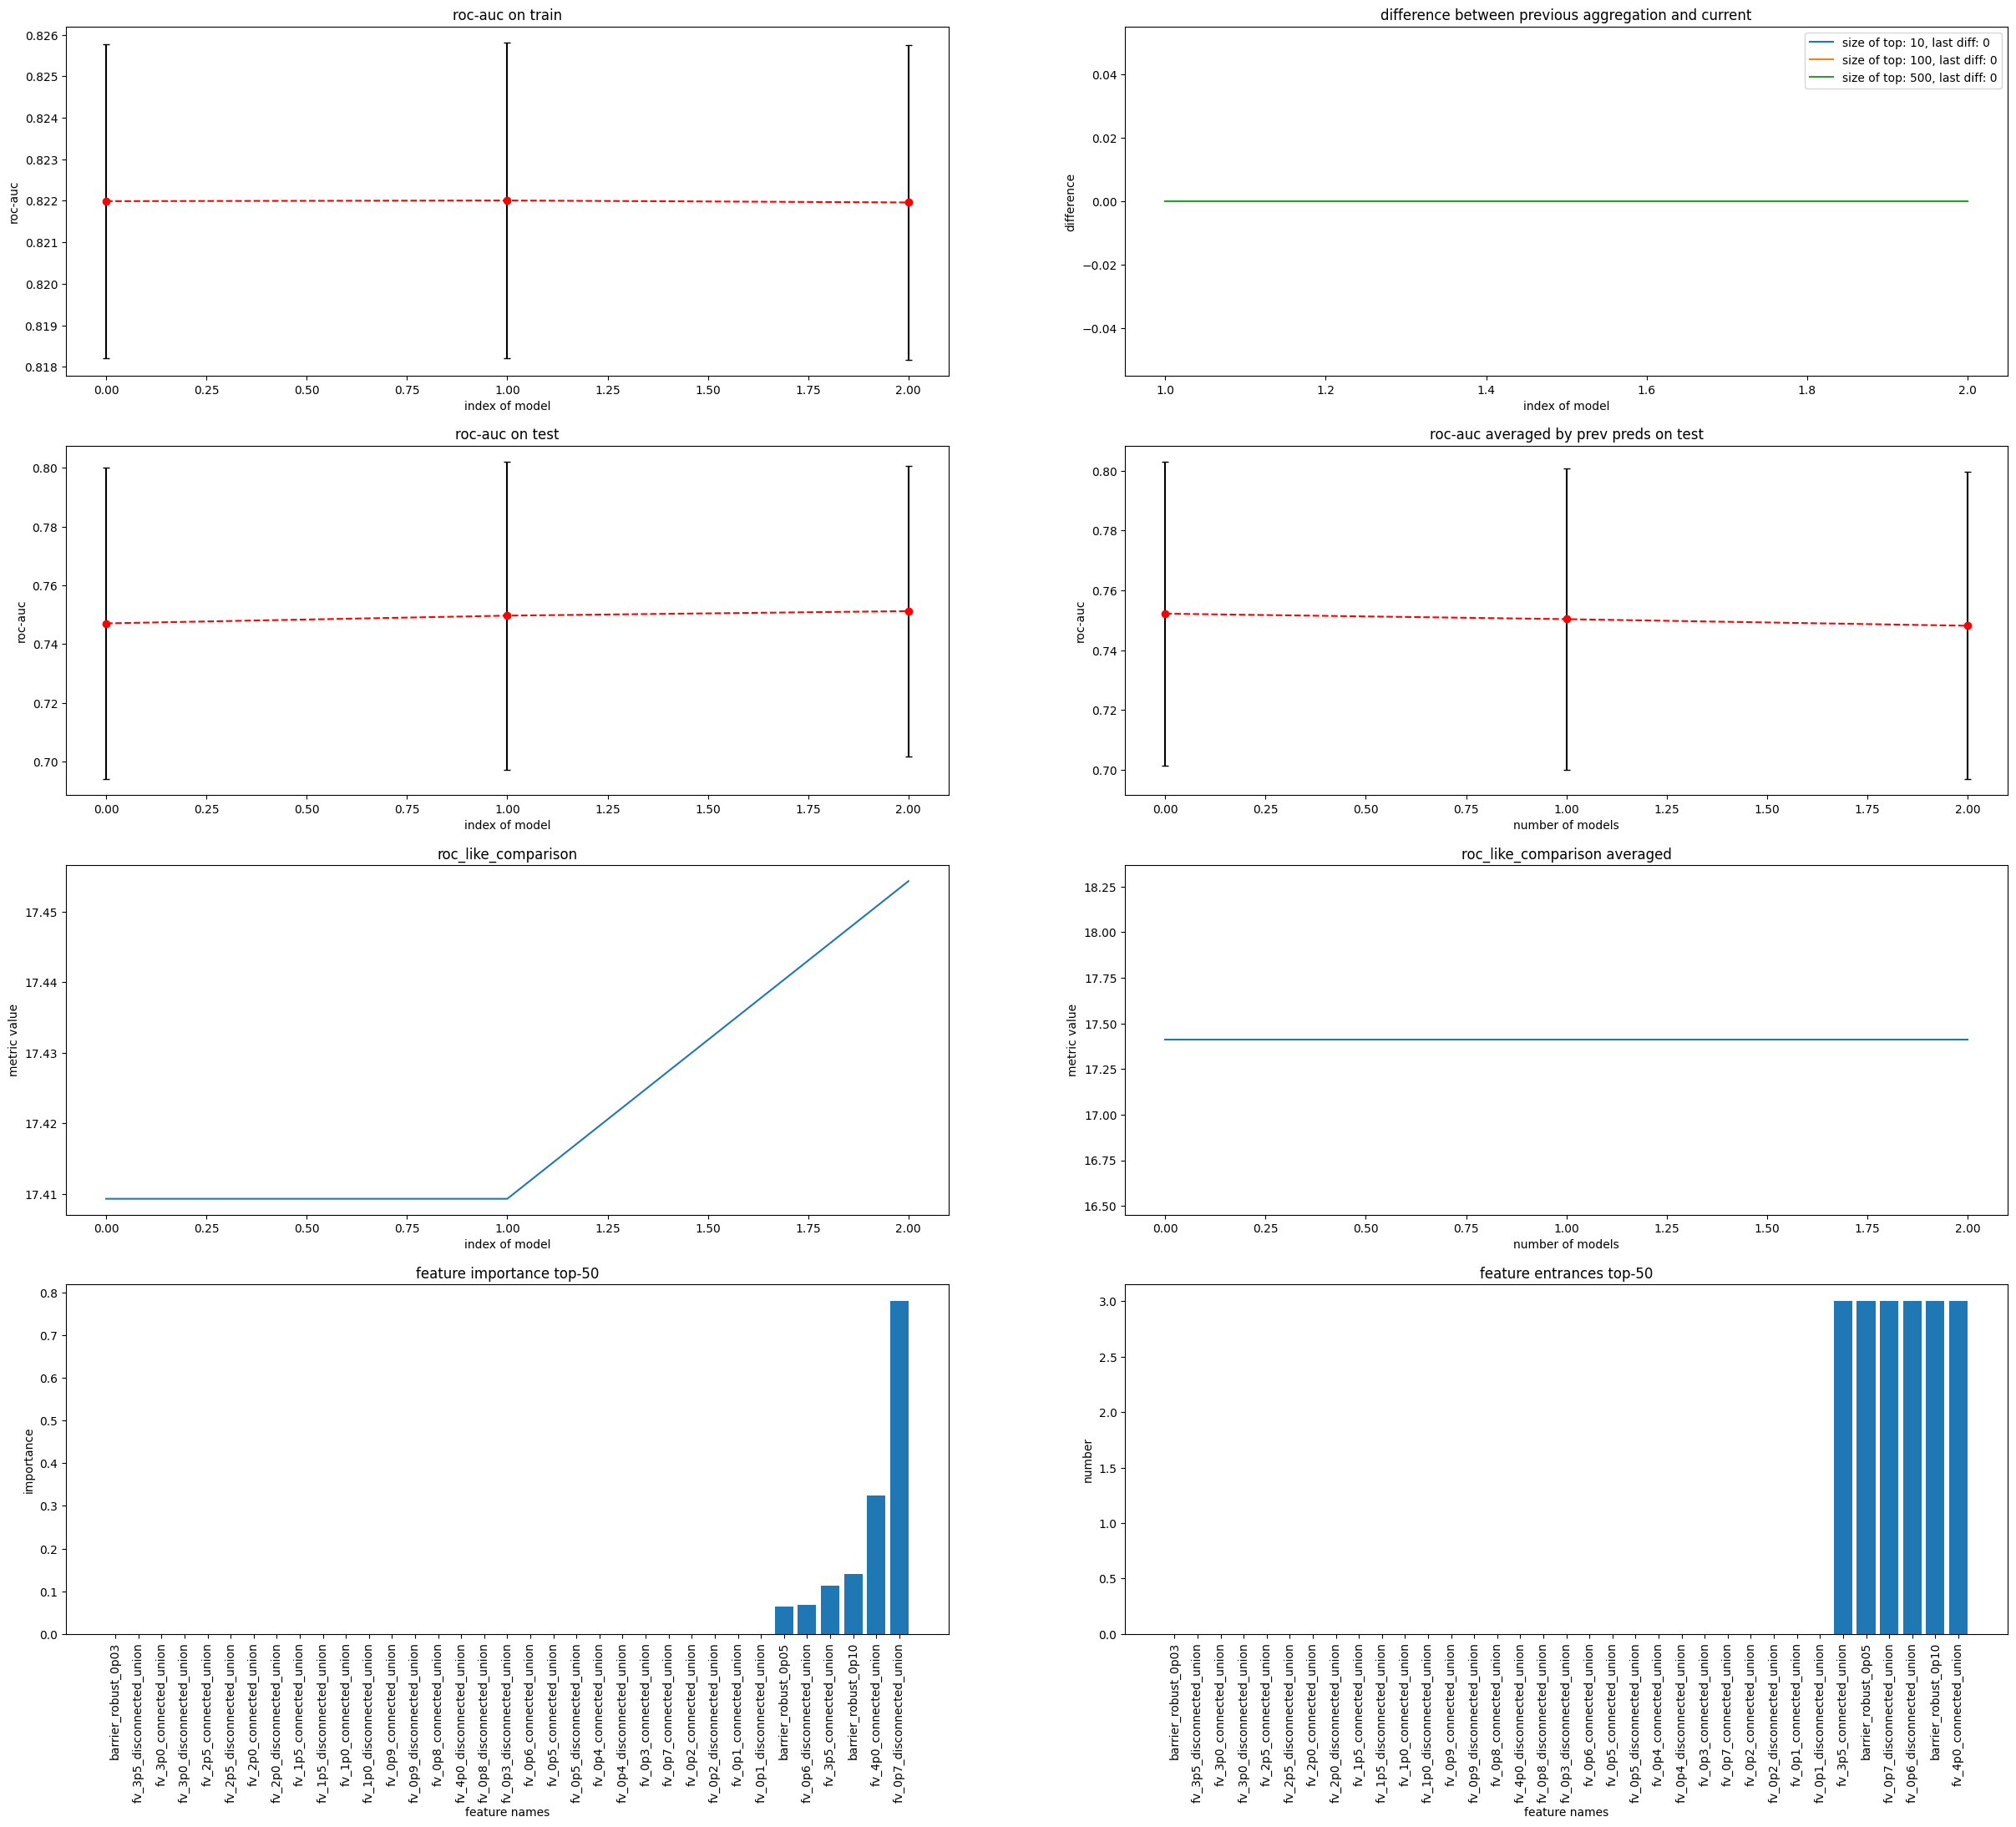

In [11]:
pipeline_logreg.plot_statistics()

In [12]:
preds_logreg_kahle = pipeline_logreg.preds_kahle_averaged[-1]
preds_logreg_mpdb = pipeline_logreg.preds_mpdb_averaged[-1]
preds_logreg_exp = pipeline_logreg.preds_exp_averaged[-1]

np.save('predictions_regression_cv_check/nn_logreg_l1_liblinear_kahle.npy', preds_logreg_kahle)
np.save('predictions_regression_cv_check/nn_logreg_l1_liblinear_mpdb.npy', preds_logreg_mpdb)
np.save('predictions_regression_cv_check/nn_logreg_l1_liblinear_exp.npy', preds_logreg_exp)


In [9]:
import warnings
warnings.filterwarnings("ignore")

params = {
    'penalty': 'l2',
    'cv': 3, 
    'scoring': 'roc_auc',
    "solver": "liblinear",
}

pipeline_logreg = ModelEvaluation(df_kahle_fin_nn, preds_Kahle2020, model_name = 'logreg', params = params)
pipeline_logreg.fit(X_kahle_nn, feature_weights_nn, thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names_nn)

pipeline_logreg.evaluate_with_cv(num_of_evaluations = 3, X_mpdb = X_mpdb_nn, X_exp = X_exp_nn)
pipeline_logreg.get_aggregated_statistics()


  0%|          | 0/3 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8023369036027264
test roc-auc mean: 0.7534341447294033, std: 0.05314918341069603
mean train roc-auc: 0.8033229421985697


  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:24<00:48, 24.35s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:48<00:24, 24.10s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:12<00:00, 24.07s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

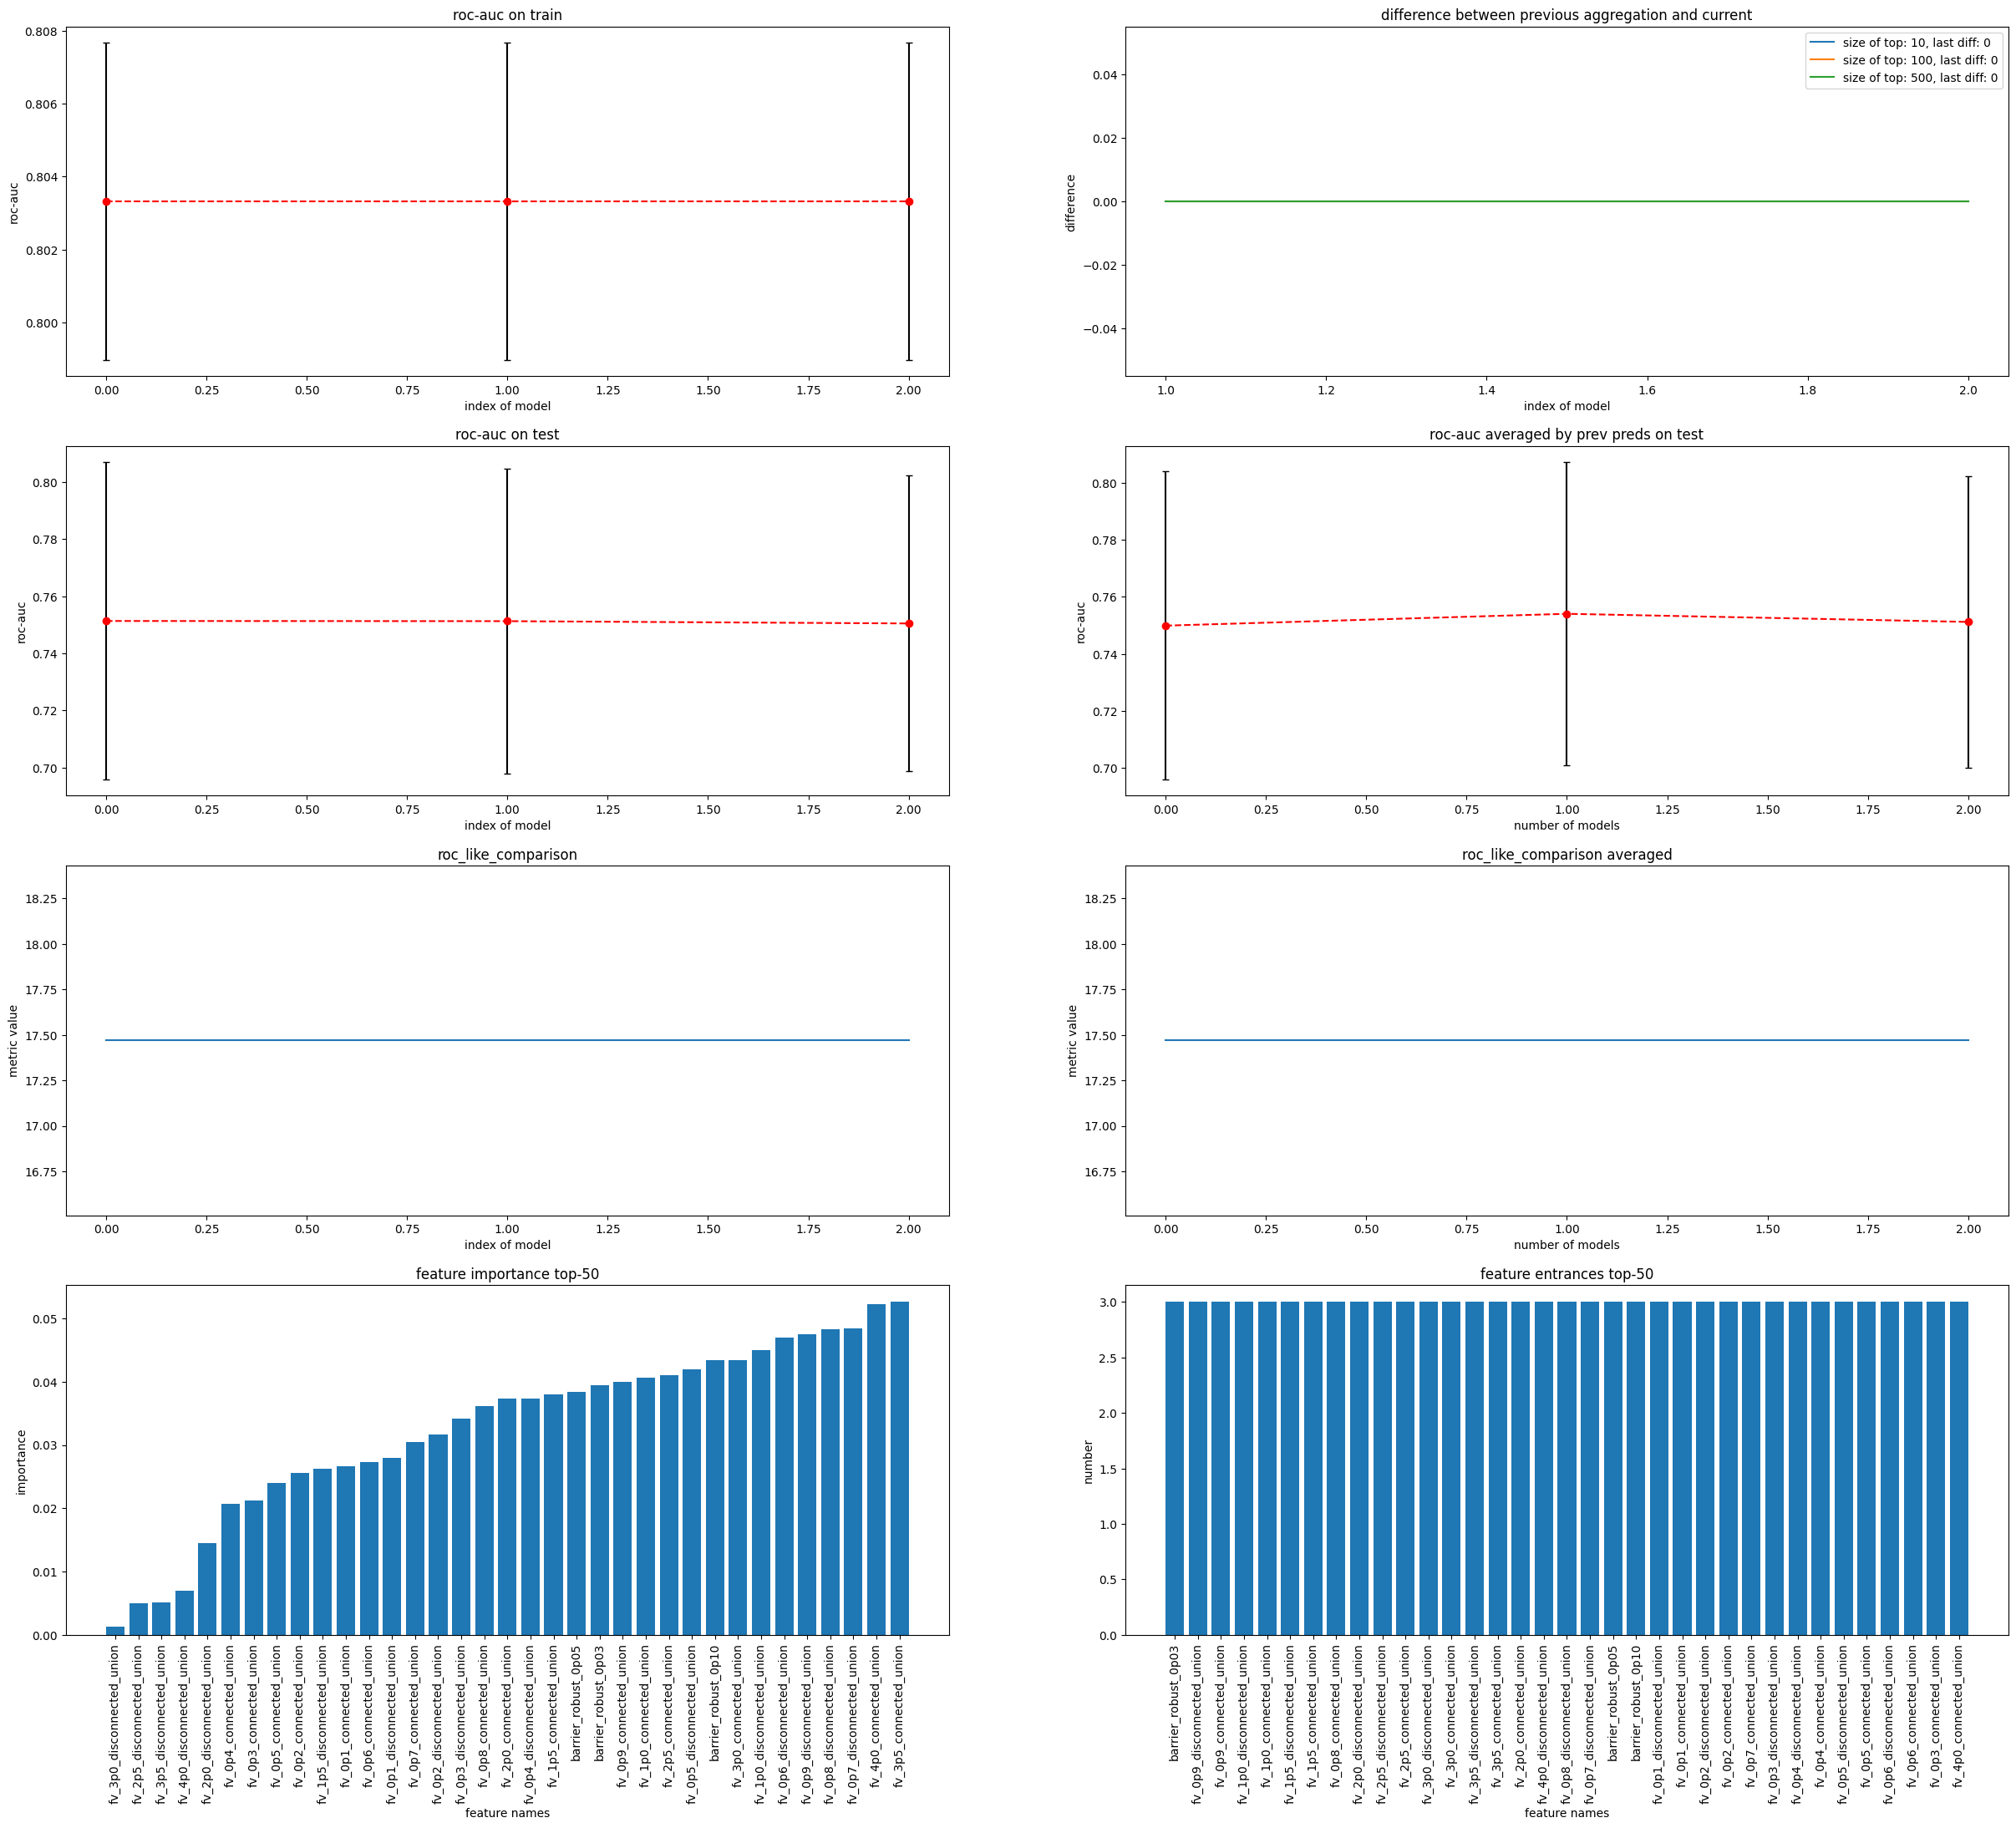

In [10]:
pipeline_logreg.plot_statistics()

In [11]:
preds_logreg_kahle = pipeline_logreg.preds_kahle_averaged[-1]
preds_logreg_mpdb = pipeline_logreg.preds_mpdb_averaged[-1]
preds_logreg_exp = pipeline_logreg.preds_exp_averaged[-1]

np.save('predictions_regression_cv_check/nn_logreg_l2_liblinear_kahle.npy', preds_logreg_kahle)
np.save('predictions_regression_cv_check/nn_logreg_l2_liblinear_mpdb.npy', preds_logreg_mpdb)
np.save('predictions_regression_cv_check/nn_logreg_l2_liblinear_exp.npy', preds_logreg_exp)


EVALUATION STEP

In [ ]:
from misc_utils import augment_Kahle2020
from misc_utils import augment_preds

from training_functions import *
from merging import *
from utils import *
from model_evaluation import ModelEvaluation
import pandas as pd

df_Kahle2020 = augment_Kahle2020.read_and_augment(
    "data_slim.csv",
)

preds_Kahle2020 = augment_preds.join_data_and_preds_Kahle2020(
    df_preds=pd.read_csv("datasets/exported.predictions.Kahle2020.v2.csv"),
    df_data=df_Kahle2020,
)

2024-09-10 15:51:39.689241: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 15:51:40.689657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Estimating lognorm D parameters


Making initial guess:   0%|          | 0/195 [00:00<?, ?it/s]

2024-09-10 15:51:54.236699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21041 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:06:00.0, compute capability: 8.6
2024-09-10 15:51:54.237318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8944 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5
2024-09-10 15:51:54.237822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9836 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


refining:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from misc_utils.feature_analysis import (
    get_features_meta_info, plot_features_Kahle2020, PairwiseComparisonMetrics, ROClikeComparisonMetrics,
    plot_feature_roclikes, add_feature, add_feature_np
)

In [ ]:
preds_logreg_kahle_nn = np.load('predictions/nn_logreg_kahle.npy', allow_pickle=True)
preds_logreg_kahle_nn.shape

(116,)

In [ ]:
preds_logreg_kahle_nn = np.load('predictions/nn_logreg_kahle.npy', allow_pickle=True)
preds_logreg_mpdb_nn = np.load('predictions/nn_logreg_mpdb.npy', allow_pickle=True)
preds_logreg_exp_nn = np.load('predictions/nn_logreg_exp.npy', allow_pickle=True)

print(preds_logreg_kahle_nn.shape)
print(preds_logreg_mpdb_nn.shape)
print(preds_logreg_exp_nn.shape)

(116,)
(5996,)
(144,)


In [ ]:
preds_catboost_kahle_nn = np.load('predictions/nn_catboost_kahle.npy', allow_pickle=True)
preds_catboost_mpdb_nn = np.load('predictions/nn_catboost_mpdb.npy', allow_pickle=True)
preds_catboost_exp_nn = np.load('predictions/nn_catboost_exp.npy', allow_pickle=True)

print(preds_catboost_kahle_nn.shape)
print(preds_catboost_mpdb_nn.shape)
print(preds_catboost_exp_nn.shape)

(116,)
(5996,)
(144,)


In [ ]:
preds_mp = pd.read_csv("datasets/exported.predictions.mp.v2.csv")
ref_mp = pd.read_csv("datasets/mp_Laskowski2023_map.csv")

preds_mp_exp = join_data_and_preds_exp(
    df_preds_full_mp=preds_mp,
    df_data_exp_mp=ref_mp,
)

preds_icsd_exp = join_data_and_preds_icsd(
    df_preds_icsd=pd.read_csv("datasets/exported.predictions.icsd.v3.csv"),
    df_data_exp_full=pd.read_csv("datasets/digitized_data_for_SSEs.csv"),
)

preds_mp_exp = pd.concat([preds_mp_exp, preds_icsd_exp], axis=0).reset_index(drop=True)


In [ ]:
all_features = get_features_meta_info(masking_options=("",))

[preds_Kahle2020, preds_mp_exp], all_features = add_feature_np(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    values = [preds_catboost_kahle_nn, preds_catboost_exp_nn],
    name = "nn_catboost",
    type = "nn_catboost",
    level=0.0,
)


[preds_Kahle2020, preds_mp_exp], all_features = add_feature_np(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    values = [preds_logreg_kahle_nn, preds_logreg_exp_nn],
    name = "nn_logreg",
    type = "nn_logreg",
    level=0.0,
)

sigmoid = lambda x, steepness=10: 1.0 / (1.0 + np.exp(-x * steepness))

[preds_Kahle2020, preds_mp_exp], all_features = add_feature(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    func=lambda x: (
        sigmoid(np.log10(x["fv_0p5_connected_union"]) + 2.00)
        * sigmoid(np.log10(x["fv_0p5_disconnected_union"]) + 1.15)
    ),
    name="manual_combination",
    type="manual_combination",
    level=0.0,
)

[preds_Kahle2020, preds_mp_exp], all_features = add_feature(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    func=lambda x: (
        np.random.default_rng(42).uniform(0.01, 1.0, size=len(x))
    ),
    name="random_guess",
    type="random_guess",
    level=0.0,
)

In [ ]:
exp_pos = preds_mp_exp.query(
    "sigma_S_cm.replace('<1E-10', '1e-10').astype('float') >= 5e-5"
)["sample_weight"].sum()
exp_neg = preds_mp_exp.query(
    "sigma_S_cm.replace('<1E-10', '1e-10').astype('float') <= 1e-5"
)["sample_weight"].sum()


sim_pos = len(preds_Kahle2020.query("log10condNE300 >= -2.5"))
sim_pos_base = len(preds_Kahle2020.query("condNE1000 >= 0.1"))
sim_neg = len(preds_Kahle2020.query("condNE1000 <= 1e-2"))

print(f"exp          p/n: {exp_pos:.0f} / {exp_neg:.0f} = {exp_pos / exp_neg:.3f}")
print(f"sim (base)   p/n: {sim_pos_base:.0f} / {sim_neg:.0f} = {sim_pos_base / sim_neg:.3f}")
print(f"sim (extrap) p/n: {sim_pos:.0f} / {sim_neg:.0f} = {sim_pos / sim_neg:.3f}")


exp          p/n: 6 / 76 = 0.079
sim (base)   p/n: 31 / 64 = 0.484
sim (extrap) p/n: 4 / 64 = 0.062


In [ ]:
roclike_metrics = ROClikeComparisonMetrics()

feature_scores_experimental = roclike_metrics.eval_features(
    preds_df=preds_mp_exp,
    features_meta_info=all_features,
    positive_thr=5e-5,
    negative_thr=1e-5,
    weight_validation_plots=False,
    dataset_type="experimental",
    experimental_error_relative=1.0,
    num_bootstrap_samples=1000,
    num_negatives_max=0.1 * exp_neg,
)

feature_scores_base = roclike_metrics.eval_features(
    preds_df=preds_Kahle2020,
    features_meta_info=all_features,
    num_bootstrap_samples=1000,
    num_negatives_max=0.1 * sim_neg,
    positive_on_extrap300=False,
    weight_validation_plots=False,
)

feature_scores_extrap300 = roclike_metrics.eval_features(
    preds_df=preds_Kahle2020,
    features_meta_info=all_features,
    num_bootstrap_samples=1000,
    # num_negatives_max=2.0,
    num_negatives_max=0.1 * sim_neg,
    positive_on_extrap300=True,
    positive_thr=-2.5,
    weight_validation_plots=False,
)


Found sample weights!


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]